# CLS Trends at the DHd Annual Conferences from 2014 to 2025
## Computational Literary Studies (CLS) Trends at DHd (2014–2025)

This Jupyter notebook analyzes trends in Computational Literary Studies (CLS) as presented in the DHd conference (Digital Humanities im deutschsprachigen Raum) from 2014 to 2025, based on metadata from abstracts, keywords, and topic models.

## Purpose
The project aims to:

Track the relative frequency of methodological groups in CLS across years
Visualize co-occurrence patterns of methods using network graphs
Surface emerging trends and popular topics based on shared terminology

## Data

The input data is assumed to be a DataFrame df with the following columns (already preloaded):

year: Year of the DHd conference
keywords: Manually or automatically assigned keywords
topics: Topic model output (optional)
top_words: List of top-ranked terms per topic
clean_abstract: Preprocessed full abstract text

## Methodology

### 1. Method Group Mapping
A manually curated dictionary (cls_keyword_groups) maps specific terms and phrases (in German and English) to broader CLS method groups, such as:

Machine Learning
Network Analysis
Stylometry
Corpus Analysis
Deep Learning & Neural Nets
Preprocessing
... and more.

### 2. Term Extraction
Each document is parsed for terms from:
- Keywords
- Topic labels
- Top words
- Abstract text
All terms are normalized and matched against the method groups.

### 3. Trend Analysis
Each abstract contributes at most one count per method group.
Trends are visualized using line charts, showing:
Absolute counts
Relative share (% of total per year)

### 4. Co-occurrence Network
Documents with multiple method groups are used to build a network graph
Nodes = Method groups
Edges = Number of co-occurrences
Visualization via Plotly for interactive exploration


In [1]:
#1. Load the Data
import pandas as pd

# Load your metadata table
# Update the path as needed

#df = pd.read_csv('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/DHd25/CLS-related_DHd_abstracts_corrected_last_version_cleaned.csv')
df = pd.read_csv('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/DHd25/CLS-related_DHd_abstracts_corrected_last_version_lemmatized.csv')
df

year conference                                           filename  \
0    2014    DHd2014                    2014_cls_metadata_extracted.csv   
1    2014    DHd2014                    2014_cls_metadata_extracted.csv   
2    2014    DHd2014                    2014_cls_metadata_extracted.csv   
3    2014    DHd2014                    2014_cls_metadata_extracted.csv   
4    2014    DHd2014                    2014_cls_metadata_extracted.csv   
..    ...        ...                                                ...   
266  2025    DHd2025  R_TTGERMANN_Julia_Qualitative_Genre_Profile_un...   
267  2025    DHd2025  GERSTORFER_Dominik_Operationalizing_operationa...   
268  2025    DHd2025  SPIELBERG_Marina_Literary_Metaphor_Detection_w...   
269  2025    DHd2025  FISCHER_Frank_Wikipedia_als_Hallraum_der_Kanon...   
270  2025    DHd2025  JANNIDIS_Fotis_M_glichkeiten_und_Grenzen_der_K...   

                                                 title  \
0    A Flexible NLP Pipeline for Computational Narr...   
1    Zwischen Ton und Textgenese: Digital gestützte...   
2    AAC-FACKEL. Das Beispiel einer digitalen Muste...   
3    Eine digitale Ausgabe des Welschen Gastes als ...   
4    Für eine computergestützte literarische Gattun...   
..                                                 ...   
266  Qualitative Genre-Profile und distinktive Wört...   
267                  Operationalizing operationalizing   
268  Literary Metaphor Detection with LLM Fine-Tuni...   
269  Wikipedia als Hallraum der Kanonizität: »1001 ...   
270  Möglichkeiten und Grenzen der KI-gestützten An...   

                                               authors  \
0    Bögel, Thomas (Heidelberg University, Germany)...   
1    Cividini, Iacopo (Stiftung Mozarteum Salzburg,...   
2    Biber, Hanno (Österreichische Akademie der Wis...   
3                                          Jakub Simek   
4    Schöch, Christof (Lehrstuhl für Computerphilol...   
..                                                 ...   
266  Julia Röttgermann (Universität Trier, Deutschl...   
267  Dominik Gerstorfer (TU-Darmstadt, Deutschland)...   
268  Marina Spielberg (Trier Center for Digital Hum...   
269  Jonas Rohe (Freie Universität Berlin, Deutschl...   
270  Merten Kröncke (Universität Würzburg, Deutschl...   

                                              keywords  \
0           NLP, Pipeline, Narratologie, Computational   
1                      Onlineedition, Digitale Edition   
2    Digitale Edition, Korpus, XML, OCR, PoS-taggin...   
3    stylometrische Analyse, Visualisierungen, Netz...   
4    computergestützte literarische Gattungsstilist...   
..                                                 ...   
266  Computational literary studies, Keyness, Disti...   
267  Operationalisierung, Explikation, Validieren, ...   
268  large language models, metaphor detection, fin...   
269   Wikipedia, Wikidata, Weltliteratur, Kanon, QRank   
270             Textannotation, Sprachmodelle, ChatGPT   

                                                topics  \
0           NLP, Pipeline, Narratologie, Computational   
1                      Onlineedition, Digitale Edition   
2    Digitale Edition, Korpus, XML, OCR, PoS-taggin...   
3    stylometrische Analyse, Visualisierungen, Netz...   
4    computergestützte literarische Gattungsstilist...   
..                                                 ...   
266                    Inhaltsanalyse, Literatur, Text   
267  Modellierung, Methoden, Forschung, Forschungsp...   
268  Programmierung, Daten, Literatur, Forschungser...   
269             Bewertung, Daten, Literatur, Werkzeuge   
270  Annotieren, Bewertung, Literatur, Forschungspr...   

                                              abstract language  \
0    1 Project Overview Temporal dependencies revea...       en   
1    Als Bestandteil einer multimedialen Gattung be...       de   
2    Die AAC-FACKEL wurde unter Anwendung corpuslin...       de   
3    Eine digitale Ausgabe des „Welschen Gastes“

In [3]:
#2a. Preprocess the Text
import spacy

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Load language models
nlp_de = spacy.load("de_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

In [3]:
#Lemmatization and language detection

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

def lemmatize_text(text, lang):
    if lang == "de":
        doc = nlp_de(text)
    elif lang == "en":
        doc = nlp_en(text)
    else:
        return text  # Fallback: return original
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha])

# Detect language for each abstract
df["language"] = df["abstract"].astype(str).apply(detect_language)

# Lemmatize and clean the abstract
df["clean_abstract"] = df.apply(
    lambda row: lemmatize_text(row["abstract"].lower(), row["language"]),
    axis=1
)



In [4]:
#2b. Save the dataframe to a new extanded csv
#df.to_csv('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/DHd25/CLS-related_DHd_abstracts_corrected_last_version_lemmatized.csv', index=False, encoding="utf-8")

In [5]:
#3. Compute TF-IDF Matrix

import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer


# Combine stopword sets
stopwords_combined = nlp_en.Defaults.stop_words.union(nlp_de.Defaults.stop_words)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["clean_abstract"])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()




In [7]:
#4. Extract Top Distinctive Words per Abstract
import numpy as np

def get_top_n_words(row_idx, top_n=10):
    row = tfidf_matrix[row_idx].toarray().flatten()
    top_indices = row.argsort()[::-1][:top_n]
    top_words = [(feature_names[i], row[i]) for i in top_indices if row[i] > 0]
    return top_words

# Create a new column with top N words
df["top_words"] = [get_top_n_words(i, top_n=10) for i in range(tfidf_matrix.shape[0])]
df

year conference                                           filename  \
0    2014    DHd2014                    2014_cls_metadata_extracted.csv   
1    2014    DHd2014                    2014_cls_metadata_extracted.csv   
2    2014    DHd2014                    2014_cls_metadata_extracted.csv   
3    2014    DHd2014                    2014_cls_metadata_extracted.csv   
4    2014    DHd2014                    2014_cls_metadata_extracted.csv   
..    ...        ...                                                ...   
266  2025    DHd2025  R_TTGERMANN_Julia_Qualitative_Genre_Profile_un...   
267  2025    DHd2025  GERSTORFER_Dominik_Operationalizing_operationa...   
268  2025    DHd2025  SPIELBERG_Marina_Literary_Metaphor_Detection_w...   
269  2025    DHd2025  FISCHER_Frank_Wikipedia_als_Hallraum_der_Kanon...   
270  2025    DHd2025  JANNIDIS_Fotis_M_glichkeiten_und_Grenzen_der_K...   

                                                 title  \
0    A Flexible NLP Pipeline for Computational Narr...   
1    Zwischen Ton und Textgenese: Digital gestützte...   
2    AAC-FACKEL. Das Beispiel einer digitalen Muste...   
3    Eine digitale Ausgabe des Welschen Gastes als ...   
4    Für eine computergestützte literarische Gattun...   
..                                                 ...   
266  Qualitative Genre-Profile und distinktive Wört...   
267                  Operationalizing operationalizing   
268  Literary Metaphor Detection with LLM Fine-Tuni...   
269  Wikipedia als Hallraum der Kanonizität: »1001 ...   
270  Möglichkeiten und Grenzen der KI-gestützten An...   

                                               authors  \
0    Bögel, Thomas (Heidelberg University, Germany)...   
1    Cividini, Iacopo (Stiftung Mozarteum Salzburg,...   
2    Biber, Hanno (Österreichische Akademie der Wis...   
3                                          Jakub Simek   
4    Schöch, Christof (Lehrstuhl für Computerphilol...   
..                                                 ...   
266  Julia Röttgermann (Universität Trier, Deutschl...   
267  Dominik Gerstorfer (TU-Darmstadt, Deutschland)...   
268  Marina Spielberg (Trier Center for Digital Hum...   
269  Jonas Rohe (Freie Universität Berlin, Deutschl...   
270  Merten Kröncke (Universität Würzburg, Deutschl...   

                                              keywords  \
0           NLP, Pipeline, Narratologie, Computational   
1                      Onlineedition, Digitale Edition   
2    Digitale Edition, Korpus, XML, OCR, PoS-taggin...   
3    stylometrische Analyse, Visualisierungen, Netz...   
4    computergestützte literarische Gattungsstilist...   
..                                                 ...   
266  Computational literary studies, Keyness, Disti...   
267  Operationalisierung, Explikation, Validieren, ...   
268  large language models, metaphor detection, fin...   
269   Wikipedia, Wikidata, Weltliteratur, Kanon, QRank   
270             Textannotation, Sprachmodelle, ChatGPT   

                                                topics  \
0           NLP, Pipeline, Narratologie, Computational   
1                      Onlineedition, Digitale Edition   
2    Digitale Edition, Korpus, XML, OCR, PoS-taggin...   
3    stylometrische Analyse, Visualisierungen, Netz...   
4    computergestützte literarische Gattungsstilist...   
..                                                 ...   
266                    Inhaltsanalyse, Literatur, Text   
267  Modellierung, Methoden, Forschung, Forschungsp...   
268  Programmierung, Daten, Literatur, Forschungser...   
269             Bewertung, Daten, Literatur, Werkzeuge   
270  Annotieren, Bewertung, Literatur, Forschungspr...   

                                              abstract language  \
0    1 Project Overview Temporal dependencies revea...       en   
1    Als Bestandteil einer multimedialen Gattung be...       de   
2    Die AAC-FACKEL wurde unter Anwendung corpuslin...       de   
3    Eine digitale Ausgabe des „Welschen Gastes“

In [8]:
#5. Save the dataframe to a new extended csv
#df.to_csv('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/DHd25/CLS-related_DHd_abstracts_corrected_last_version_cleaned_plus_mdw.csv', index=False, encoding="utf-8")

In [9]:
#6. Create Interactive Plotly Visualization
#!pip install plotly ipywidgets

#6a. Prepare the Data for Plotting
import plotly.express as px
import pandas as pd
from ipywidgets import interact, IntSlider

# Convert top_words to a DataFrame for easy plotting
def prepare_plot_data(abstract_idx):
    words_scores = df.loc[abstract_idx, "top_words"]
    if not words_scores:
        return pd.DataFrame(columns=["word", "score"])
    words, scores = zip(*words_scores)
    return pd.DataFrame({"word": words, "score": scores})


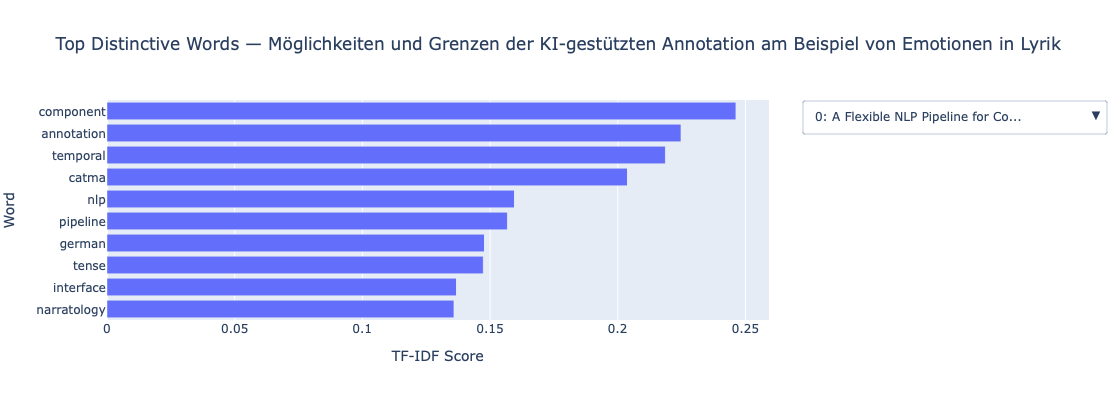

In [11]:
import plotly.graph_objects as go
import pandas as pd

# Assuming df already exists and contains the "top_words" column as list of (word, score) tuples

# Start with data from the first abstract
initial_idx = 0
initial_top_words = df.loc[initial_idx, "top_words"]
words, scores = zip(*initial_top_words) if initial_top_words else ([], [])
title = df.loc[initial_idx, "title"]

# Create the figure with just one bar trace
fig = go.Figure()

bar = go.Bar(
    x=scores,
    y=words,
    orientation='h'
)
fig.add_trace(bar)

# Build the dropdown menu options
dropdown_buttons = []
for i, row in df.iterrows():
    top_words = row["top_words"]
    words, scores = zip(*top_words) if top_words else ([], [])
    title = row["title"]

    dropdown_buttons.append(dict(
        label=f"{i}: {title[:30]}...",  # Shorten label for dropdown
        method="update",
        args=[
            {"x": [scores], "y": [words]},  # update data
            {"title": f"Top Distinctive Words — {title}"}
        ]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top"
    )],
    title=f"Top Distinctive Words — {title}",
    yaxis=dict(autorange="reversed"),
    xaxis_title="TF-IDF Score",
    yaxis_title="Word",
    height=400
)


# Save to HTML
#fig.write_html('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/DHd25/top_words_interactive.html', full_html=True, include_plotlyjs='cdn')


## Define groups of words related to common CLS methods for clustered keyword analysis and visualization

In [13]:
cls_keyword_groups = {
    "network analysis": [
        "network", "netzwerk", "netzwerke", "netzwerkanalyse", 
        "network analysis", "sozialen netzwerke", "soziale netzwerke", "soziales netzwerk", "netzwerkmodell"
    ],
    "annotation": [
        "annotation", "annotieren", "goldannotation", "gold annotation", "guidelines", "annotation guidelines", "richtlinien", "annotationsrichtlinien",
        "inter annotator agreement", "annotator", "intra annotator agreement", "annotator disagreement"
    ],
    "sentiment/emotion analysis": [
        "sentiment analysis", "sentimentanalyse", "emotion", 
        "emotionen", "gefühlsanalyse", "gefühl", "emotionsanalyse", 
        "affekt", "affektanalyse", "stimmungsanalyse"
    ],
    "machine learning (general)": [
        "machine learning", "maschinelles lernen", "prediction model", 
        "vorhersagemodell", "supervised learning", "unsupervised learning", 
        "classification", "klassifikation", "regression", "modellierung"
    ],
    "word embeddings": [
        "embedding", "embeddings", "word embedding", 
        "word2vec", "fasttext", "glove", "vektorraum", 
        "vektorrepräsentation", "doc2vec", "vector space", "vector"
    ],
    "visualization & interactivity": [
        "visualization", "visualisation", "interactive visualization", 
        "interaktive visualisierung", "visualisierung", "graph", 
        "netzwerkgraph", "plot", "diagramm", "datavis"
    ],
    "corpus & textual analysis": [
        "corpus analysis", "korpusanalyse", "corpus", "korpus", 
        "korpora", "corpora", "textanalyse", "text mining", 
        "textstatistik", "korpuslinguistik", "korpusliteraturwissenschaft"
    ],
    "large language models (LLMs)": [
        "large language model", "llm", "llms", "gpt", "llama", "ollama",
        "generative model", "generative", "textgenerierung", "ai", "generative ai", "ki",
        "generative ki", "openai", "text synthesis"
    ],
    "language models": [
        "language model", "language models", "transformer", "bert", "classification", "klassifikation", "sprachmodel"
    ],
    "clustering & pattern detection": [
        "clustering", "cluster", "muster", "mustererkennung", 
        "regelmäßigkeit", "unsupervised", "gruppierung", "ähnlichkeitsanalyse"
    ],
    "deep learning & neural nets": [
        "deep learning", "neuronale netze", "neural network", 
        "cnn", "rnn", "lstm", "transformer architektur", 
        "tiefes lernen", "deep neural"
    ],
    "computational literary studies (CLS)": [
        "computational literary studies", 
        "computational methods", "computationell", "CLS", 
        "digitale literaturwissenschaft", "digital literary studies", 
        "literatur und computer", "algorithmen und literatur"
    ],
    "topic modeling": [
        "topic modeling", "lda", "latent dirichlet allocation", 
        "themenerkennung", "thematische analyse", "topics", "topic"
    ],
    "stylometry & authorship": [
        "stylometry", "stylometrie", "autorschaftsanalyse", 
        "author attribution", "stilometrie", "autorenerkennung", 
        "stiluntersuchung", "stylo"
    ],
    "genre classification": [
        "genre", "genres", "genrerkennung", "genrezuordnung", 
        "genre classification", "gattung", "gattungsanalyse"
    ],
    "preprocessing": [
        "preprocessing", "part of speech", "pos-tagging", "lemmatization", 
        "lemmatisierung", "pre-processing", "pos-tagger", "tagger", "pos-tagger", "lemmatizer", "tokenisierung", "tokeniser", "tokenization", "normalisierung", "normalization"
    ]
}


In the following network:
Each node is a methodological group from your cls_keyword_groups (e.g., topic modeling, sentiment analysis, LLMs, etc.).

Each edge represents co-occurrence:
Two groups are connected if they were both mentioned (via keywords, topics, top words, or abstract text) in the same abstract.

The thicker the edge, the more often that pair of groups co-occurred across abstracts.

Node size (if enabled) or label prominence isn't dynamic here, but:
A highly connected node (many edges) = A method that is used with many others → interdisciplinary.
A sparse node (few edges) = A method that is used more independently or in a specialized way.
Edge thickness indicates how frequently two method categories co-occur:
Thick edge between "topic modeling" and "machine learning" → These two methods frequently appear together in the same studies.
A lack of connection = Rare or no co-usage in your corpus.

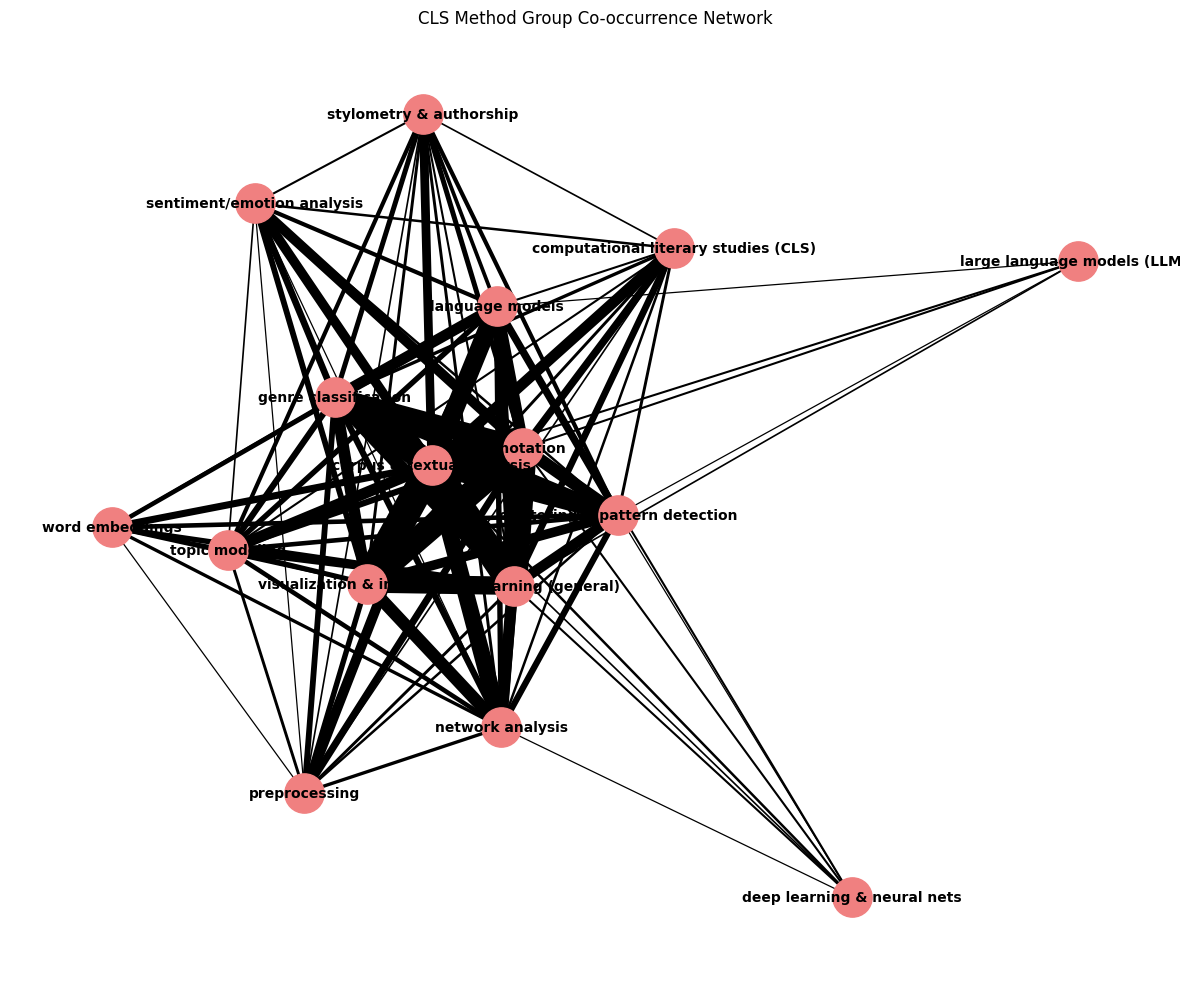

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

# STEP 1 — Normalize group keywords into a lookup
cls_lookup = {}
for group, keywords in cls_keyword_groups.items():
    for kw in keywords:
        cls_lookup[kw.lower()] = group

# STEP 2 — Extract all relevant term sources
def extract_all_terms(row):
    terms = []

    # From keywords and topics columns
    for col in ["keywords", "topics"]:
        col_terms = row.get(col)
        if pd.notnull(col_terms):
            terms += [t.strip().lower() for t in col_terms.split(",") if len(t.strip()) > 1]

    # From top_words list of tuples
    if isinstance(row.get("top_words"), list):
        terms += [word.lower() for word, _ in row["top_words"]]

    # From clean_abstract
    if isinstance(row.get("clean_abstract"), str):
        terms += row["clean_abstract"].lower().split()

    return terms

# Apply term extraction
df["all_raw_terms"] = df.apply(extract_all_terms, axis=1)

# STEP 3 — Map terms to CLS method groups
def map_to_groups(term_list):
    return [cls_lookup[term] for term in term_list if term in cls_lookup]

df["mapped_terms"] = df["all_raw_terms"].apply(map_to_groups)

# Filter to only rows with at least 2 matched CLS groups
df_filtered = df[df["mapped_terms"].str.len() > 1].copy()

# STEP 4 — Build co-occurrence graph
G = nx.Graph()
for terms in df_filtered["mapped_terms"]:
    for term1, term2 in combinations(set(terms), 2):
        if G.has_edge(term1, term2):
            G[term1][term2]["weight"] += 1
        else:
            G.add_edge(term1, term2, weight=1)

# STEP 5 — Plot the graph
plt.figure(figsize=(12, 10))
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
H = nx.Graph()
H.add_edges_from([(u, v, d) for u, v, d in top_edges])

pos = nx.spring_layout(H, seed=42)
nx.draw_networkx_nodes(H, pos, node_size=800, node_color="lightcoral")
nx.draw_networkx_edges(H, pos, width=[d['weight'] * 0.3 for _, _, d in H.edges(data=True)])
nx.draw_networkx_labels(H, pos, font_size=10, font_weight="bold")

plt.title("CLS Method Group Co-occurrence Network")
plt.axis("off")
plt.tight_layout()
plt.show()


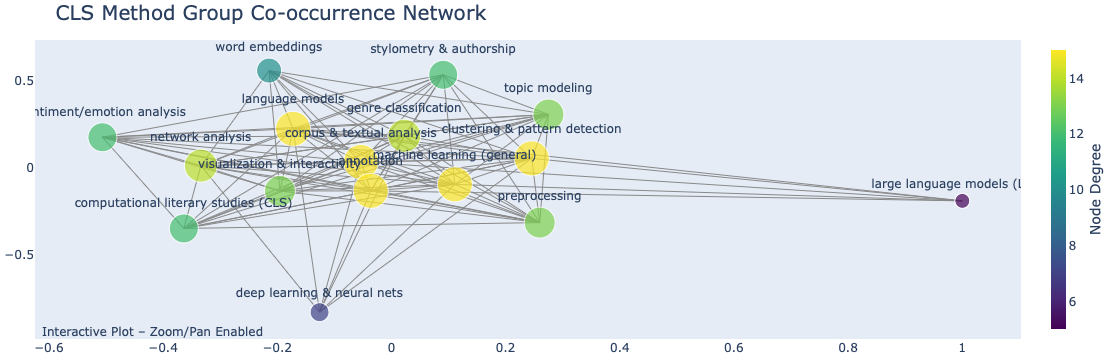

In [17]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations

# STEP 1 — Normalize group keywords into a lookup
cls_lookup = {}
for group, keywords in cls_keyword_groups.items():
    for kw in keywords:
        cls_lookup[kw.lower()] = group

# STEP 2 — Extract all relevant term sources
def extract_all_terms(row):
    terms = []
    for col in ["keywords", "topics"]:
        col_terms = row[col]
        if pd.notnull(col_terms):
            terms += [t.strip().lower() for t in col_terms.split(",") if len(t.strip()) > 1]
    if isinstance(row.get("top_words"), list):
        terms += [word.lower() for word, _ in row["top_words"]]
    if isinstance(row.get("clean_abstract"), str):
        terms += row["clean_abstract"].lower().split()
    return terms

df["all_raw_terms"] = df.apply(extract_all_terms, axis=1)

# STEP 3 — Map to method groups
def map_to_groups(term_list):
    return [cls_lookup[term] for term in term_list if term in cls_lookup]

df["mapped_terms"] = df["all_raw_terms"].apply(map_to_groups)
df = df[df["mapped_terms"].str.len() > 1]

# STEP 4 — Build co-occurrence graph
G = nx.Graph()
for terms in df["mapped_terms"]:
    for term1, term2 in combinations(set(terms), 2):
        if G.has_edge(term1, term2):
            G[term1][term2]["weight"] += 1
        else:
            G.add_edge(term1, term2, weight=1)

# Optional: Filter top edges by weight
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
H = nx.Graph()
H.add_edges_from(top_edges)

# Use spring layout
pos = nx.spring_layout(H, seed=42, k=0.5)

# Prepare Plotly edge traces
edge_x = []
edge_y = []
edge_weights = []

for u, v, data in H.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_weights.append(data["weight"])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="#888"),
    hoverinfo="none",
    mode="lines"
)

# Prepare Plotly node traces
node_x = []
node_y = []
node_text = []

for node in H.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>Connections: {H.degree[node]}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers+text",
    text=[node for node in H.nodes()],
    textposition="top center",
    hovertext=node_text,
    hoverinfo="text",
    marker=dict(
        showscale=True,
        colorscale="Viridis",
        color=[H.degree[node] for node in H.nodes()],
        size=[5 + H.degree[node]*2 for node in H.nodes()],
        colorbar=dict(
            thickness=15,
            title="Node Degree",
            xanchor="left",
            titleside="right"
        ),
        line_width=1
    )
)

# Final interactive figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="CLS Method Group Co-occurrence Network",
                    titlefont_size=20,
                    showlegend=False,
                    hovermode="closest",
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Interactive Plot – Zoom/Pan Enabled",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002
                    )],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()


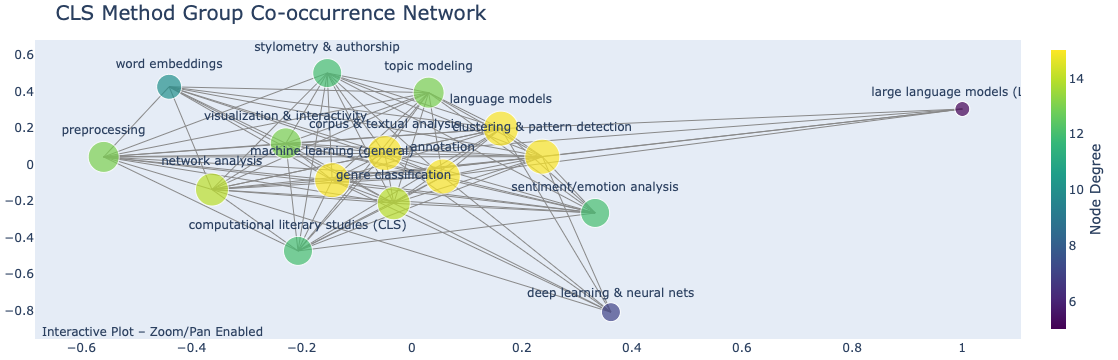

In [19]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations

# STEP 1 — Normalize group keywords into a lookup
cls_lookup = {}
for group, keywords in cls_keyword_groups.items():
    for kw in keywords:
        cls_lookup[kw.lower()] = group

# STEP 2 — Extract all relevant term sources
def extract_all_terms(row):
    terms = []
    for col in ["keywords", "topics"]:
        col_terms = row[col]
        if pd.notnull(col_terms):
            terms += [t.strip().lower() for t in col_terms.split(",") if len(t.strip()) > 1]
    if isinstance(row.get("top_words"), list):
        terms += [word.lower() for word, _ in row["top_words"]]
    if isinstance(row.get("clean_abstract"), str):
        terms += row["clean_abstract"].lower().split()
    return terms

df = df.copy()  # Prevent chained assignment warning
df["all_raw_terms"] = df.apply(extract_all_terms, axis=1)

# STEP 3 — Map to method groups (deduplicated per abstract)
def map_to_groups(term_list):
    return list(set(cls_lookup[term] for term in term_list if term in cls_lookup))

df["mapped_terms"] = df["all_raw_terms"].apply(map_to_groups)

# STEP 4 — Keep only rows with multiple mapped groups
df = df[df["mapped_terms"].str.len() > 1].copy()  # Ensure no view-based chaining

# STEP 5 — Build co-occurrence graph
G = nx.Graph()
for terms in df["mapped_terms"]:
    for term1, term2 in combinations(sorted(terms), 2):
        if G.has_edge(term1, term2):
            G[term1][term2]["weight"] += 1
        else:
            G.add_edge(term1, term2, weight=1)

# Optional: Filter top edges by weight
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
H = nx.Graph()
H.add_edges_from(top_edges)

# Layout for visualization
pos = nx.spring_layout(H, seed=42, k=0.5)

# Edge traces
edge_x, edge_y = [], []
for u, v in H.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="#888"),
    hoverinfo="none",
    mode="lines"
)

# Node traces
node_x, node_y, node_text = [], [], []
for node in H.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>Connections: {H.degree[node]}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers+text",
    text=list(H.nodes()),
    textposition="top center",
    hovertext=node_text,
    hoverinfo="text",
    marker=dict(
        showscale=True,
        colorscale="Viridis",
        color=[H.degree[node] for node in H.nodes()],
        size=[5 + H.degree[node]*2 for node in H.nodes()],
        colorbar=dict(
            thickness=15,
            title="Node Degree",
            xanchor="left",
            titleside="right"
        ),
        line_width=1
    )
)

# Final interactive figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="CLS Method Group Co-occurrence Network",
                    titlefont_size=20,
                    showlegend=False,
                    hovermode="closest",
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Interactive Plot – Zoom/Pan Enabled",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002
                    )],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()


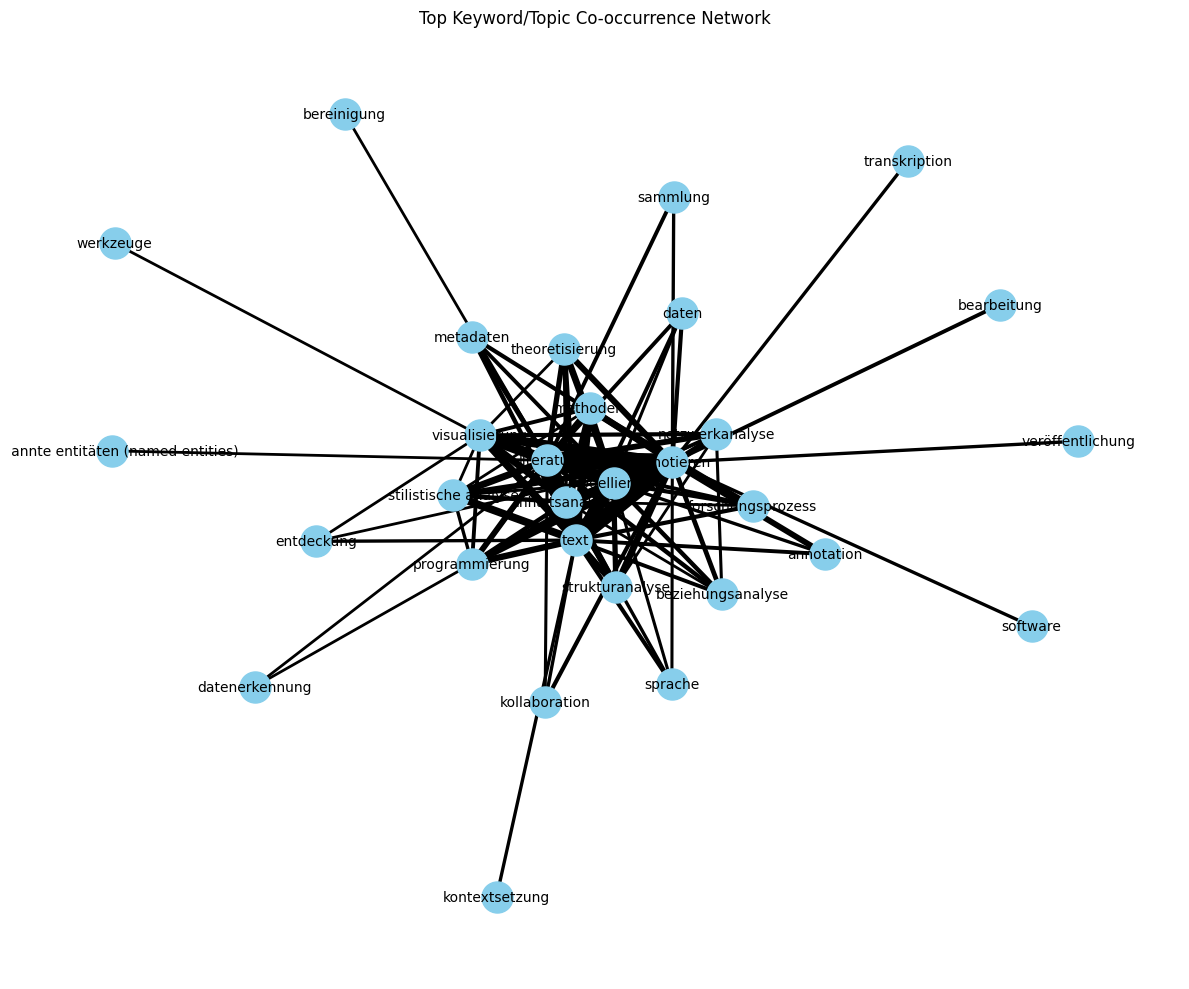

In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Start with a clean copy of your DataFrame
df_cleaned = df.copy()

# STEP 1 — Clean and split keywords & topics
df_cleaned["keywords_list"] = df_cleaned["keywords"].fillna("").str.lower().str.split(r",\s*")
df_cleaned["topics_list"] = df_cleaned["topics"].fillna("").str.lower().str.split(r",\s*")

# STEP 2 — Combine both lists and strip entries
df_cleaned["all_terms"] = df_cleaned.apply(
    lambda row: [term.strip() for term in row["keywords_list"] + row["topics_list"] if len(term.strip()) > 1],
    axis=1
)

# STEP 3 — Build co-occurrence graph
G = nx.Graph()
for terms in df_cleaned["all_terms"]:
    for term1, term2 in combinations(set(terms), 2):  # Use set to avoid self-loops
        if G.has_edge(term1, term2):
            G[term1][term2]["weight"] += 1
        else:
            G.add_edge(term1, term2, weight=1)

# STEP 4 — Plot the top N edges
plt.figure(figsize=(12, 10))

# Select top 100 edges by weight
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:100]
H = nx.Graph()
H.add_edges_from([(u, v, d) for u, v, d in top_edges])

pos = nx.spring_layout(H, seed=42)

# Draw the graph
nx.draw_networkx_nodes(H, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(H, pos, width=[d["weight"] * 0.2 for _, _, d in H.edges(data=True)])
nx.draw_networkx_labels(H, pos, font_size=10)

plt.title("Top Keyword/Topic Co-occurrence Network")
plt.axis("off")
plt.tight_layout()
plt.show()



## For the following network visualization:
Big nodes = important connectors (high betweenness centrality).
Same-colored nodes = same topic cluster (automatically detected).
Helps you see thematic clusters and important linking terms.

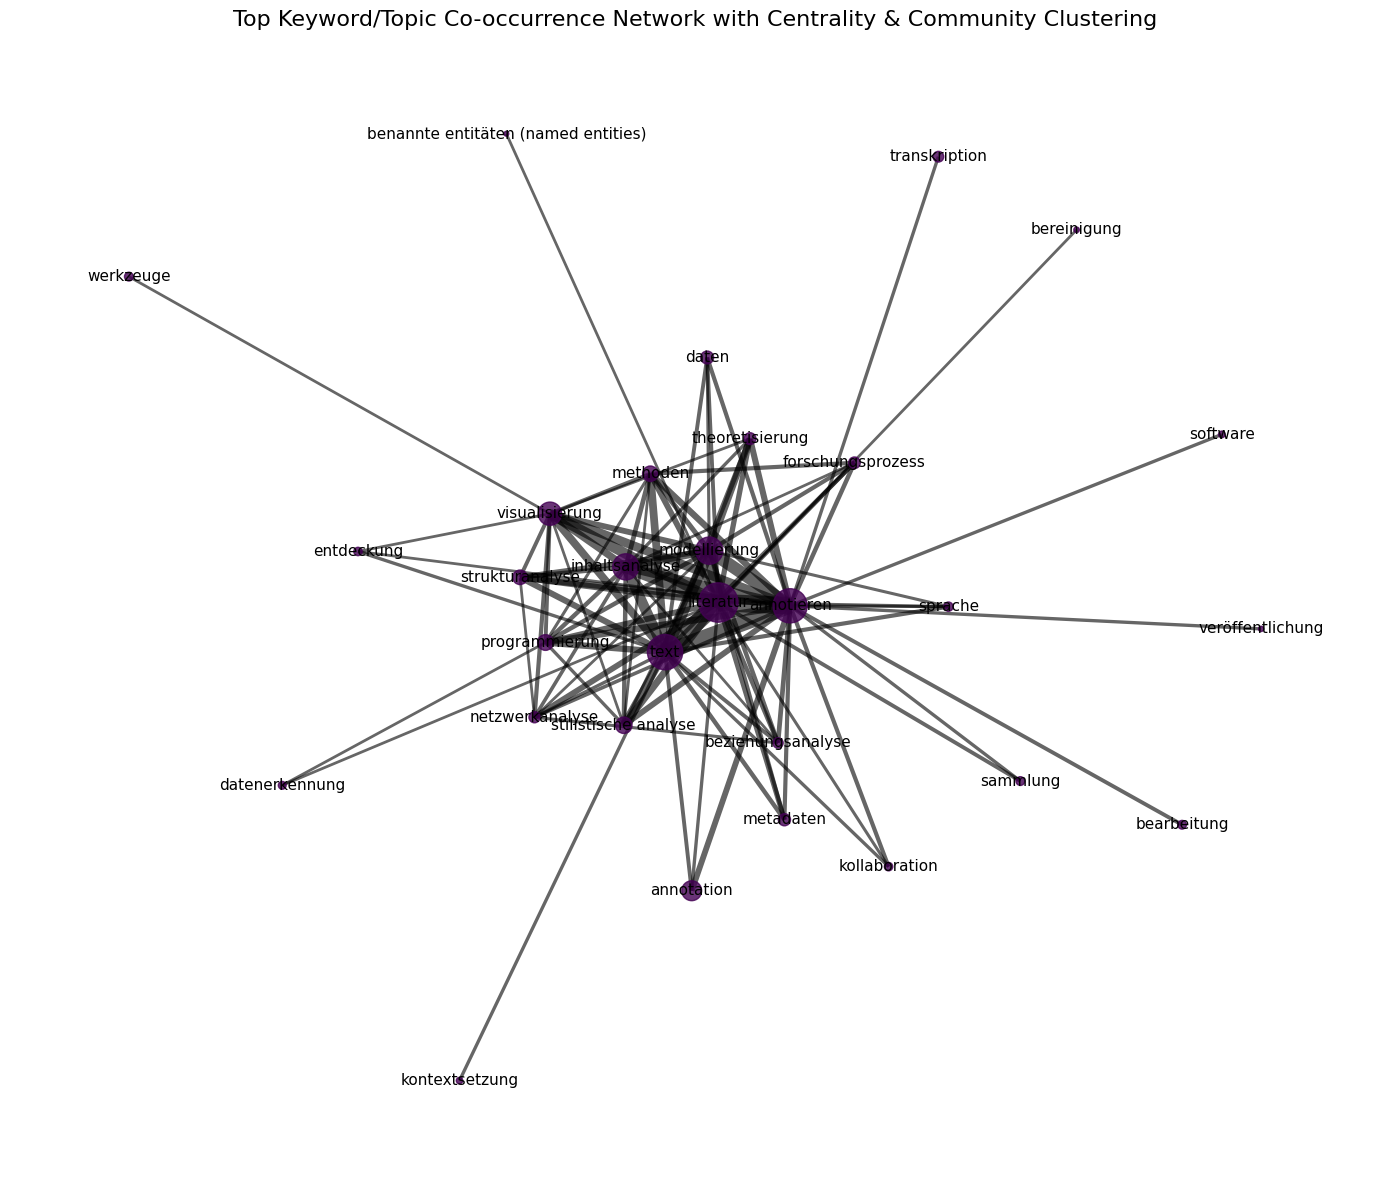

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

# === STEP 1: Work on a clean copy of the DataFrame ===
df_cleaned = df.copy()

# === STEP 2: Clean and split keywords & topics ===
df_cleaned["keywords_list"] = df_cleaned["keywords"].fillna("").str.lower().str.split(r",\s*")
df_cleaned["topics_list"] = df_cleaned["topics"].fillna("").str.lower().str.split(r",\s*")

# === STEP 3: Combine and clean all terms ===
df_cleaned["all_terms"] = df_cleaned.apply(
    lambda row: [t.strip() for t in row["keywords_list"] + row["topics_list"] if len(t.strip()) > 1],
    axis=1
)

# === STEP 4: Build co-occurrence graph ===
G = nx.Graph()
for terms in df_cleaned["all_terms"]:
    for term1, term2 in combinations(set(terms), 2):  # Avoid self-loops
        if G.has_edge(term1, term2):
            G[term1][term2]["weight"] += 1
        else:
            G.add_edge(term1, term2, weight=1)

# === STEP 5: Centrality and Community Detection ===
centrality = nx.betweenness_centrality(G)
communities = list(nx.community.label_propagation_communities(G))

# Map nodes to communities
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# === STEP 6: Plot the Network ===
plt.figure(figsize=(14, 12))

# Limit to top 100 edges for readability
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:100]
H = nx.Graph()
H.add_edges_from([(u, v, d) for u, v, d in top_edges])

# Positioning
pos = nx.spring_layout(H, seed=42, k=0.15)

# Prepare node attributes
node_sizes = [centrality.get(node, 0) * 5000 for node in H.nodes()]
node_colors = [community_map.get(node, -1) for node in H.nodes()]

# Draw network
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(H, pos, width=[d["weight"] * 0.2 for _, _, d in H.edges(data=True)], alpha=0.6)
nx.draw_networkx_labels(H, pos, font_size=11, font_color="black")

# Title and layout
plt.title("Top Keyword/Topic Co-occurrence Network with Centrality & Community Clustering", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


## The following are trend analysis 

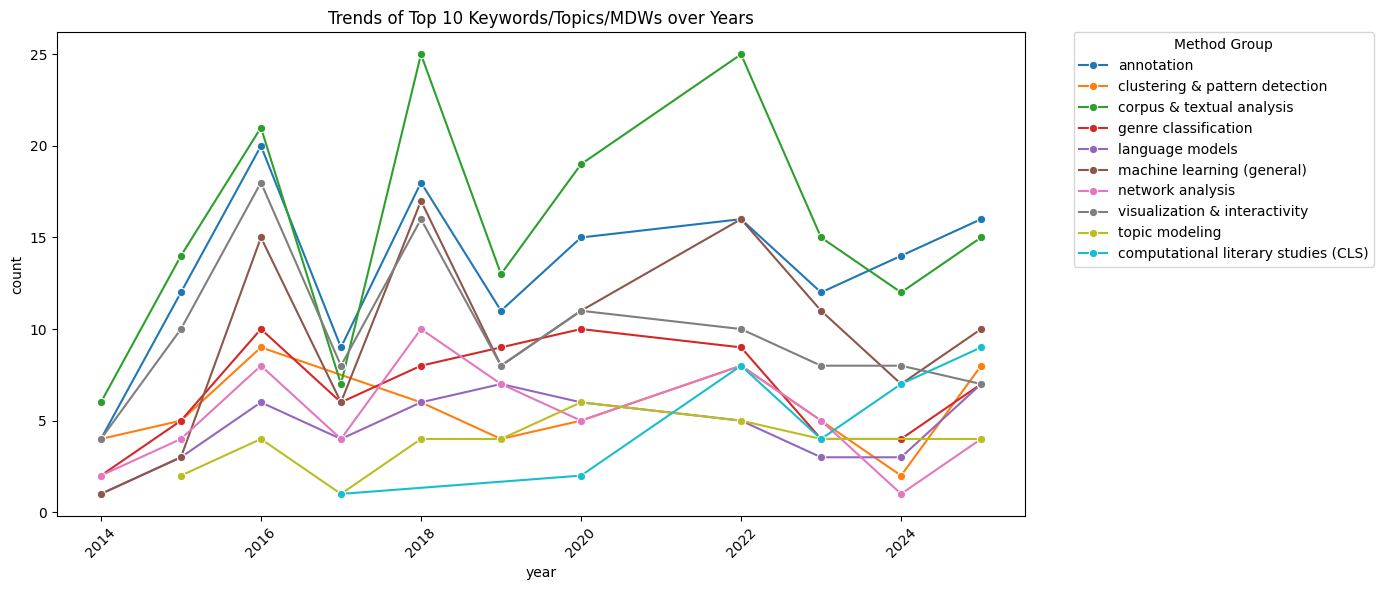

In [25]:
# Flatten terms for trend analysis
exploded = df.explode("mapped_terms")  # This will create a new row for each term in 'all_terms'
trend = exploded.groupby(["year", "mapped_terms"]).size().reset_index(name="count")  # Count occurrences of each term per year

# Top 10 terms based on total occurrences
top_terms = trend.groupby("mapped_terms")["count"].sum().nlargest(10).index  # Get the top 10 terms with the highest total occurrences across all years

# Plotting the trends of the top 10 terms without normalization 
plt.figure(figsize=(14, 6))
sns.lineplot(data=trend[trend["mapped_terms"].isin(top_terms)],  # Filter the data to include only top 10 terms
             x="year", y="count", hue="mapped_terms", marker="o")  # Plot the trends of the top terms

# Move legend outside the plot
plt.legend(
    title="Method Group",
    bbox_to_anchor=(1.05, 1),  # Position: right side
    loc='upper left',
    borderaxespad=0
)
plt.title("Trends of Top 10 Keywords/Topics/MDWs over Years")
plt.xticks(rotation=45)  # Rotate the x-axis labels to make them readable
plt.tight_layout()  # Ensure the plot fits neatly
plt.show()


Right now, .explode("mapped_terms") counts every instance of a method group (term) per abstract. This means:

- If a single abstract mentions the same group term 3 times (e.g. "machine learning, machine learning, machine learning"), it will be counted 3 times.
- This over-represents documents that happen to be longer or more repetitive.

To fix this and ensure that each abstract gives only one vote per term, you should deduplicate the mapped_terms before exploding:


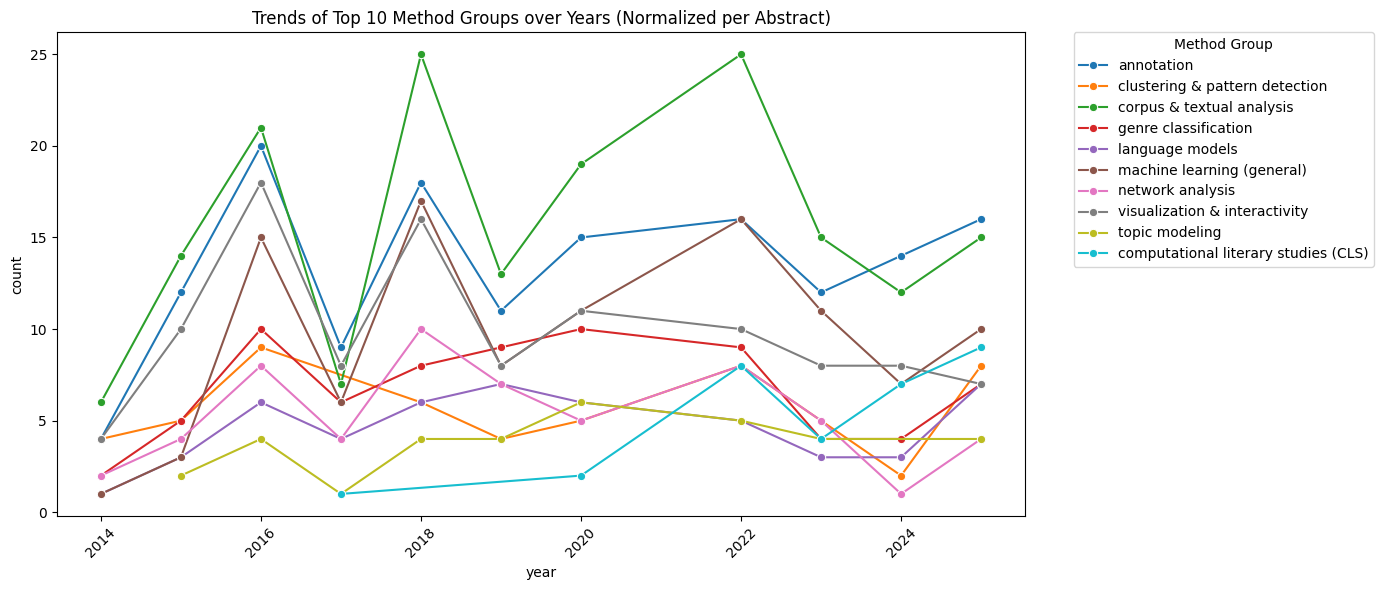

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Work on a copy to avoid SettingWithCopyWarning
df_trend = df.copy()

# STEP 2: Normalize — one vote per abstract per method group
df_trend["unique_mapped_terms"] = df_trend["mapped_terms"].apply(lambda x: list(set(x)) if isinstance(x, list) else [])

# STEP 3: Flatten for trend analysis
exploded = df_trend.explode("unique_mapped_terms")

# STEP 4: Group by year and method group
trend = exploded.groupby(["year", "unique_mapped_terms"]).size().reset_index(name="count")

# STEP 5: Find top 10 terms overall
top_terms = trend.groupby("unique_mapped_terms")["count"].sum().nlargest(10).index

# STEP 6: Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=trend[trend["unique_mapped_terms"].isin(top_terms)],
    x="year", y="count", hue="unique_mapped_terms", marker="o"
)

# Move legend outside the plot
plt.legend(
    title="Method Group",
    bbox_to_anchor=(1.05, 1),  # Position: right side
    loc='upper left',
    borderaxespad=0
)
plt.title("Trends of Top 10 Method Groups over Years (Normalized per Abstract)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Still a problem with the data: now each abstract is only counted once, but there are abstracts covering more than one keyword and I still want to know which of the methods is more present. 

- Avoid double-counting the same keyword multiple times in a single abstract.
- Still allow multiple distinct keywords per abstract to contribute (each once).
- Make sure each (abstract × method group) pair contributes exactly 1 count.


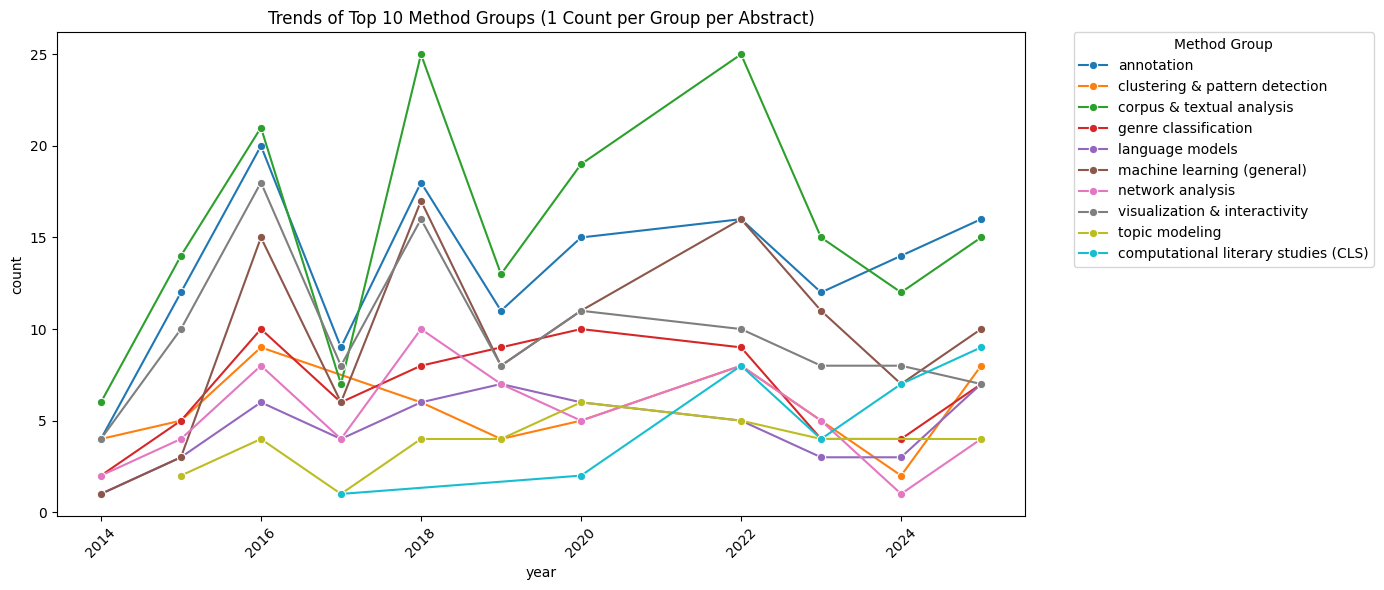

In [29]:
# Step 1: Create a copy to avoid SettingWithCopyWarning
df_clean = df.copy()

# Step 2: Ensure one count per method group per abstract (deduplicated), but allow multiple groups
df_clean["unique_mapped_terms"] = df_clean["mapped_terms"].apply(lambda terms: list(set(terms)))

# Step 3: Explode to one row per (abstract × method group)
exploded = df_clean[["year", "unique_mapped_terms"]].explode("unique_mapped_terms")

# Step 4: Group and count (each abstract contributes once per method group)
trend = exploded.groupby(["year", "unique_mapped_terms"]).size().reset_index(name="count")

# Step 5: Identify top 10 method groups by total count
top_terms = trend.groupby("unique_mapped_terms")["count"].sum().nlargest(10).index

# Step 6: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=trend[trend["unique_mapped_terms"].isin(top_terms)],
    x="year", y="count", hue="unique_mapped_terms", marker="o"
)
# Move legend outside the plot
plt.legend(
    title="Method Group",
    bbox_to_anchor=(1.05, 1),  # Position: right side
    loc='upper left',
    borderaxespad=0
)

plt.title("Trends of Top 10 Method Groups (1 Count per Group per Abstract)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


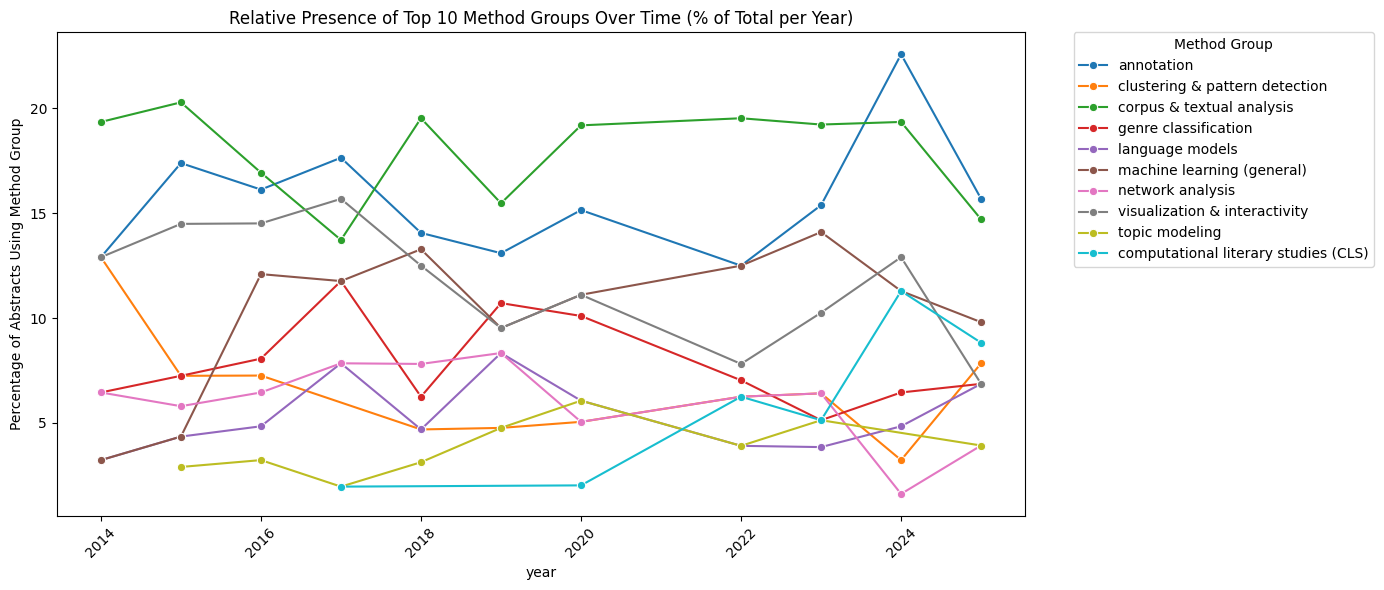

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a copy to avoid SettingWithCopyWarning
df_clean = df.copy()

# Step 2: Deduplicate to one count per method group per abstract
df_clean["unique_mapped_terms"] = df_clean["mapped_terms"].apply(lambda terms: list(set(terms)))

# Step 3: Explode for (year × method group)
exploded = df_clean[["year", "unique_mapped_terms"]].explode("unique_mapped_terms")

# Step 4: Count frequency
trend = exploded.groupby(["year", "unique_mapped_terms"]).size().reset_index(name="count")

# Step 5: Compute relative share per year
year_totals = trend.groupby("year")["count"].sum().reset_index(name="year_total")
trend = trend.merge(year_totals, on="year")
trend["percentage"] = trend["count"] / trend["year_total"] * 100

# Step 6: Filter top 10 terms
top_terms = trend.groupby("unique_mapped_terms")["count"].sum().nlargest(10).index
plot_data = trend[trend["unique_mapped_terms"].isin(top_terms)]

# Step 7: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=plot_data,
    x="year", y="percentage", hue="unique_mapped_terms", marker="o"
)

plt.title("Relative Presence of Top 10 Method Groups Over Time (% of Total per Year)")
plt.ylabel("Percentage of Abstracts Using Method Group")
plt.xticks(rotation=45)

# Move legend outside the plot
plt.legend(
    title="Method Group",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()


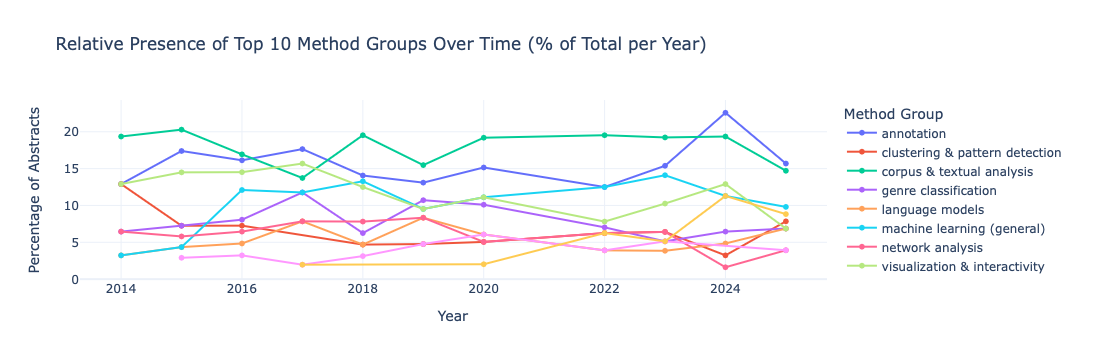

In [33]:
import plotly.express as px

# Filter to top 10 terms
plot_data = trend[trend["unique_mapped_terms"].isin(top_terms)]

# Rename for prettier labels in Plotly
plot_data = plot_data.rename(columns={
    "unique_mapped_terms": "Method Group",
    "percentage": "Relative Share (%)"
})

# Create interactive line plot
fig = px.line(
    plot_data,
    x="year",
    y="Relative Share (%)",
    color="Method Group",
    markers=True,
    title="Relative Presence of Top 10 Method Groups Over Time (% of Total per Year)",
    hover_data=["year", "Method Group", "Relative Share (%)"]
)

# Improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Percentage of Abstracts",
    legend_title="Method Group",
    hovermode="x unified",
    template="plotly_white"
)

# Show plot
fig.show()


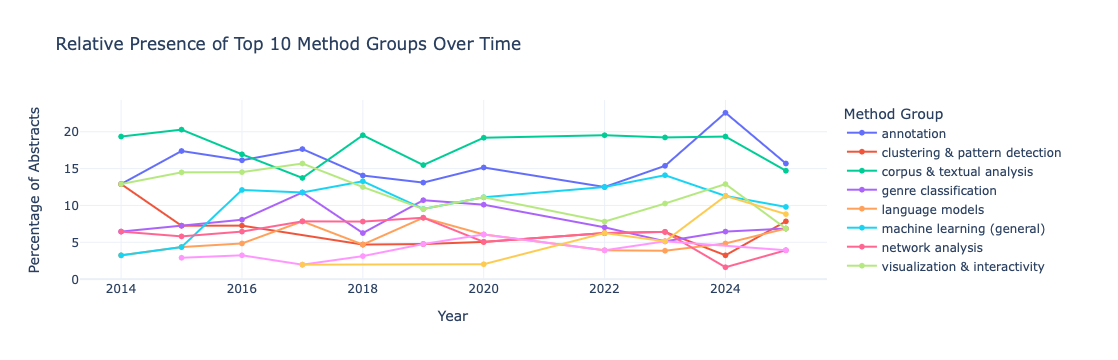

In [35]:
import plotly.express as px

# Filter to top 10 terms
plot_data = trend[trend["unique_mapped_terms"].isin(top_terms)].copy()

# Rename for labels
plot_data = plot_data.rename(columns={
    "unique_mapped_terms": "Method Group",
    "percentage": "Relative Share (%)"
})

# Format percentage to 2 decimals
plot_data["Relative Share (%)"] = plot_data["Relative Share (%)"].round(2)

# Create interactive plot
fig = px.line(
    plot_data,
    x="year",
    y="Relative Share (%)",
    color="Method Group",
    markers=True,
    title="Relative Presence of Top 10 Method Groups Over Time",
    hover_name="Method Group",
    hover_data={"Method Group": False, "Relative Share (%)": True, "year": True}
)

# Improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Percentage of Abstracts",
    legend_title="Method Group",
    hovermode="closest",  # ← Show only one point on hover
    template="plotly_white"
)

fig.show()
